/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
         LayerNorm-2             [-1, 3136, 96]             192
        PatchEmbed-3             [-1, 3136, 96]               0
           Dropout-4             [-1, 3136, 96]               0
         LayerNorm-5             [-1, 3136, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49, 49]               0
           Dropout-8            [-1, 3, 49, 49]               0
            Linear-9               [-1, 49, 96]           9,312
          Dropout-10               [-1, 49, 96]               0
  WindowAttention-11               [-1, 49, 96]               0
         Identity-12             [-1, 3136, 96]               0
        LayerNorm-13             [-1, 3136, 96]             192
           Linear-14            [-1, 31

/root/miniconda3/lib/python3.8/site-packages/timm/models/swin_transformer.py:98: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
/root/miniconda3/lib/python3.8/site-packages/timm/models/swin_transformer.py:174: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  qk

FLOPs: 288539443200
Validation loss decreased (inf --> 0.783530). Saving model ...
Epoch 1/100, Train Loss: 0.9499, Train Acc: 0.5316, Val Loss: 0.7835, Val Acc: 0.5713, Val AUC (OVO): 0.6733, Val F1: 0.5713, Val Recall: 0.5713
EarlyStopping counter: 1 out of 10
Epoch 2/100, Train Loss: 0.8328, Train Acc: 0.5715, Val Loss: 0.7843, Val Acc: 0.6000, Val AUC (OVO): 0.6879, Val F1: 0.6000, Val Recall: 0.6000
Validation loss decreased (0.783530 --> 0.726680). Saving model ...
Epoch 3/100, Train Loss: 0.7669, Train Acc: 0.6130, Val Loss: 0.7267, Val Acc: 0.6539, Val AUC (OVO): 0.7981, Val F1: 0.6539, Val Recall: 0.6539
Validation loss decreased (0.726680 --> 0.589359). Saving model ...
Epoch 4/100, Train Loss: 0.6749, Train Acc: 0.6832, Val Loss: 0.5894, Val Acc: 0.7278, Val AUC (OVO): 0.8337, Val F1: 0.7278, Val Recall: 0.7278
Validation loss decreased (0.589359 --> 0.503462). Saving model ...
Epoch 5/100, Train Loss: 0.6299, Train Acc: 0.7183, Val Loss: 0.5035, Val Acc: 0.7704, Val AUC (OV

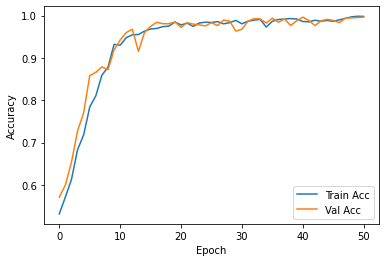

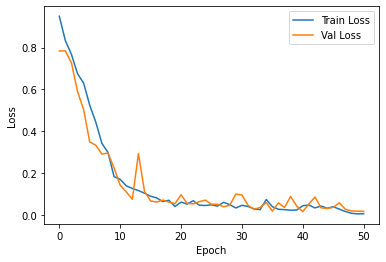

Test Acc: 0.8137, AUC (OVO): 0.9265, F1 score: 0.8137, recall: 0.8137


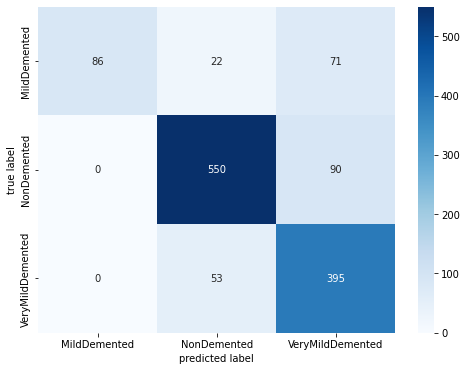

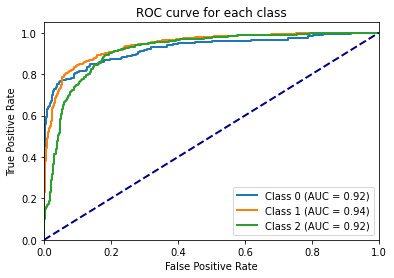

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
from torchsummary import summary
from fvcore.nn import FlopCountAnalysis

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练 Swin Transformer 模型，输出类别改为 3
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=3).to(device)
summary(model, input_size=(3, 224, 224))

# Load the pre-trained model's state dictionary
pretrained_model_path = "swin_tiny_patch4_window7_224.pth"
pretrained_state_dict = torch.load(pretrained_model_path, map_location=torch.device('cuda'))['model']

# Change the output layer's weights and biases to match your model's output layer size
pretrained_state_dict['head.weight'] = pretrained_state_dict['head.weight'][:3, :]
pretrained_state_dict['head.bias'] = pretrained_state_dict['head.bias'][:3]

# Load the modified state dictionary into your model
model.load_state_dict(pretrained_state_dict)

# 数据预处理
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_and_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 数据集路径
data_dir = "./NewThree_Dataset"  # 新的三分类数据集路径

# 加载数据集
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_and_test_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_and_test_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 设置损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# Early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_loss = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True)

# 计算FLOPs
model.eval()
batch = next(iter(val_loader))
images, _ = batch
images = images.to(device)
flops = FlopCountAnalysis(model, images)
print(f"FLOPs: {flops.total()}")

# 训练和验证循环
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
val_auc_history = []
val_f1_history = []
val_r_history = []

num_epochs = 100

for epoch in range(num_epochs):
    # Training
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_outputs_list = []
    val_labels_list = []
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_outputs_list.append(outputs.cpu().numpy())
            val_labels_list.append(labels.cpu().numpy())

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        val_outputs = np.concatenate(val_outputs_list, axis=0)
        val_labels = np.concatenate(val_labels_list, axis=0)
        val_labels_binary = label_binarize(val_labels, classes=[0, 1, 2])

        val_auc_ovo = roc_auc_score(val_labels_binary, val_outputs, multi_class='ovo')
        val_auc_history.append(val_auc_ovo)
        val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1), average='micro')
        val_f1_history.append(val_f1)
        val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1), average='micro')
        val_r_history.append(val_r)

        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("early-stop")
            break

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC (OVO): {val_auc_ovo:.4f}, "
              f"Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}")

print('training complete')
torch.save(model.state_dict(), "swin_model_alzheimer_three.pth")

# Plot training and validation metrics
plt.figure()
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.append(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.concatenate(y_scores, axis=0)
y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

acc = accuracy_score(y_true,y_pred)
auc_score_ovo = roc_auc_score(y_true_binary, y_scores, multi_class='ovo')
f1 = f1_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')

print(f"Test Acc: {acc:.4f}, AUC (OVO): {auc_score_ovo:.4f}, F1 score: {f1:.4f}, recall: {recall:.4f}")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['MildDemented', 'NonDemented', 'VeryMildDemented'], 
            yticklabels=['MildDemented', 'NonDemented', 'VeryMildDemented'])
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

# ROC curves
plt.figure()
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each class')
plt.legend(loc="lower right")
plt.show()